In [67]:
import numpy as np
from scipy.spatial import cKDTree
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import os

In [112]:
# Import the npz data from the experiments which are stored in experiment_outputs_different_starts all with the same structure
folder = 'experiment_outputs_same_starts_copy'
filenames = os.listdir(folder)
# Load the data from each file and store it in a list
data = []
nuclei_data = []
starting_positions = []
all_trails = []
for filename in filenames:
    if filename.endswith('.npz'):
        filepath = os.path.join(folder, filename)
        with np.load(filepath) as npzfile:
            data.append(npzfile)
            nuclei_data.append(npzfile['nuclei'])
            starting_positions.append(npzfile['start_pos'])
            all_trails.append(npzfile['all_trails'])

with np.load(os.path.join(folder, filenames[0])) as npzfile:
    # Extract the map and stations from the first file
    map_with_stations = npzfile['map_with_stations']
    stations = npzfile['stations']

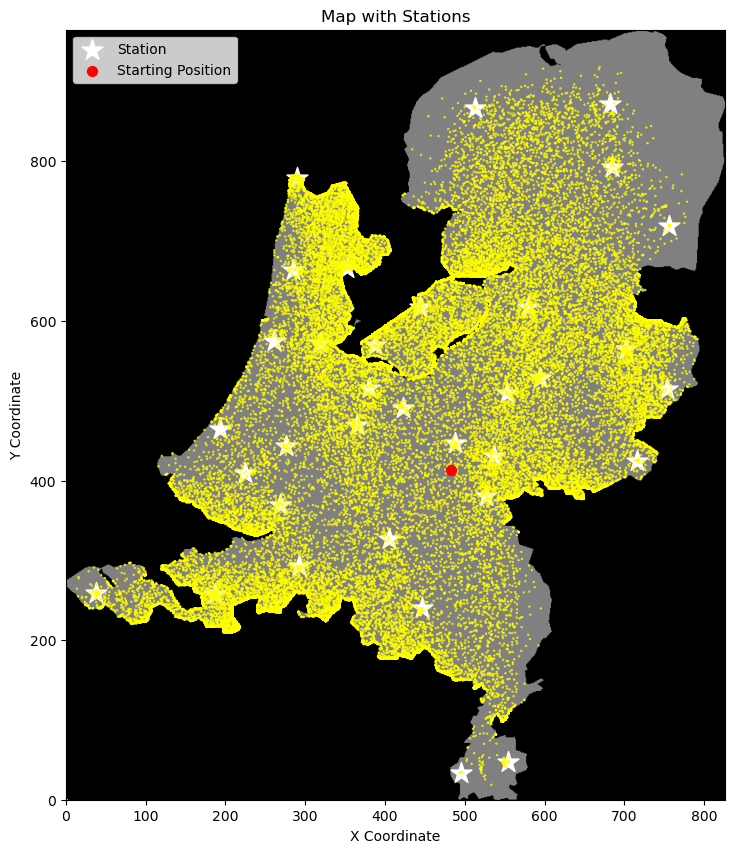

In [196]:
# visualize the map with stations
def visualize_map_with_stations(map_with_stations, stations, nuclei = None, starting_positions = None):
    plt.figure(figsize=(10, 10))
    plt.imshow(map_with_stations.T, cmap='gray')
    plt.scatter(stations[:, 0], stations[:, 1], c='white', marker='*', s=250, label='Station')
    if nuclei is not None:
        plt.scatter(nuclei[:,:,0].flatten(), nuclei[:,:,1].flatten(), c='yellow', alpha=0.8, s=3, edgecolors='none')
    if starting_positions is not None:
        plt.scatter(starting_positions[0], starting_positions[1], c='red', marker='o', s=50, label='Starting Position')
    plt.title('Map with Stations')
    plt.xlabel('X Coordinate')
    plt.ylabel('Y Coordinate')
    plt.xlim(0, map_with_stations.shape[0])
    plt.ylim(0, map_with_stations.shape[1])  # Invert y-axis to match image coordinates
    plt.legend()
    plt.show()
    
# For the first file, visualize the nuclei
visualize_map_with_stations(map_with_stations, stations, all_trails[0][::20], starting_positions[0])

In [146]:
def bresenham_line(x0, y0, x1, y1):
    """Yield integer coordinates on the line from (x0, y0) to (x1, y1) using Bresenham's algorithm."""
    x0, y0, x1, y1 = int(round(x0)), int(round(y0)), int(round(x1)), int(round(y1))
    dx = abs(x1 - x0)
    dy = abs(y1 - y0)
    x, y = x0, y0
    sx = 1 if x0 < x1 else -1
    sy = 1 if y0 < y1 else -1
    if dx > dy:
        err = dx / 2.0
        while x != x1:
            yield x, y
            err -= dy
            if err < 0:
                y += sy
                err += dx
            x += sx
        yield x, y
    else:
        err = dy / 2.0
        while y != y1:
            yield x, y
            err -= dx
            if err < 0:
                x += sx
                err += dy
            y += sy
        yield x, y

def prune_edges_by_map(edges, all_points, map_with_stations, max_water_crossings=2):
    pruned_edges = []
    for i, j in edges:
        x0, y0 = all_points[i]
        x1, y1 = all_points[j]
        # Sample the line between the two points
        line_pixels = list(bresenham_line(x0, y0, x1, y1))
        # Count how many pixels cross water (0)
        water_crossings = sum(
            map_with_stations[int(x), int(y)] == 0
            for x, y in line_pixels
            if 0 <= int(x) < map_with_stations.shape[0] and 0 <= int(y) < map_with_stations.shape[1]
        )
        if water_crossings <= max_water_crossings:
            pruned_edges.append((i, j))
    return np.array(pruned_edges)

In [197]:
def build_proximity_graph(nuclei, stations, pm=10):
    """
    Build a proximity graph from nuclei and stations.
    
    Args:
        nuclei: (T, N, 2) or (M, 2) array of nuclei positions (can be flattened).
        stations: (K, 2) array of station positions.
        pm: Number of nearest neighbors to connect.
        
    Returns:
        all_points: (P, 2) array of all points (nuclei + stations).
        edges: (E, 2) array of edge indices (into all_points).
        G: networkx.Graph with weighted edges.
    """
    # Flatten nuclei if needed and remove zero rows
    points = nuclei.reshape(-1, 2)
    points = points[~np.all(points == 0, axis=1)]
    station_points = np.array(stations)
    all_points = np.vstack([points, station_points])

    # Build KDTree for fast neighbor search
    tree = cKDTree(all_points)
    dists, idxs = tree.query(all_points, k=pm+1)  # +1 because first neighbor is itself

    # Build edge list
    src = np.repeat(np.arange(idxs.shape[0]), idxs.shape[1] - 1)
    dst = idxs[:, 1:].reshape(-1)
    edges = np.stack([src, dst], axis=1)

    # Build weighted graph
    G = nx.Graph()
    diffs = all_points[edges[:, 0]] - all_points[edges[:, 1]]
    weights = np.linalg.norm(diffs, axis=1)
    G.add_weighted_edges_from([(int(i), int(j), float(w)) for (i, j), w in zip(edges, weights)])

    return all_points, edges, G

In [198]:
from matplotlib.collections import LineCollection

def visualize_mesh_with_background(points, edges, station_points, map_with_stations, 
                                  title='10-Nearest Neighbor Proximity Mesh', 
                                  save_path=None):
    """
    Visualize a mesh network on top of a map using LineCollection for edges.
    
    Args:
        points: (N, 2) array of all node coordinates (x, y).
        edges: (M, 2) array of edge indices (into points).
        station_points: (K, 2) array of station coordinates (x, y).
        map_with_stations: 2D array for the background map.
        title: Title for the plot.
        save_path: If given, save the figure to this path.
    """
    # Prepare edge segments for LineCollection
    edge_segments = np.stack([
        np.stack([points[edges[:, 0]], points[edges[:, 1]]], axis=1)
    ], axis=0).reshape(-1, 2, 2)

    fig, ax = plt.subplots(figsize=(10, 10))
    ax.set_facecolor('black')
    ax.imshow(map_with_stations.T, cmap='gray', origin='lower')

    # Draw all edges at once
    lc = LineCollection(edge_segments, colors='yellow', linewidths=0.5, alpha=0.5)
    ax.add_collection(lc)

    # Draw points
    ax.scatter(points[:, 0], points[:, 1], c='white', s=2)
    ax.scatter(station_points[:, 0], station_points[:, 1], c='white', marker='*', s=250, label='station Source')

    ax.set_xlim(0, map_with_stations.shape[0])
    ax.set_ylim(0, map_with_stations.shape[1])
    ax.set_title(title, color='white')
    ax.legend(facecolor='white', framealpha=0.7, loc='upper right')
    ax.tick_params(colors='white')
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=300)
    plt.show()

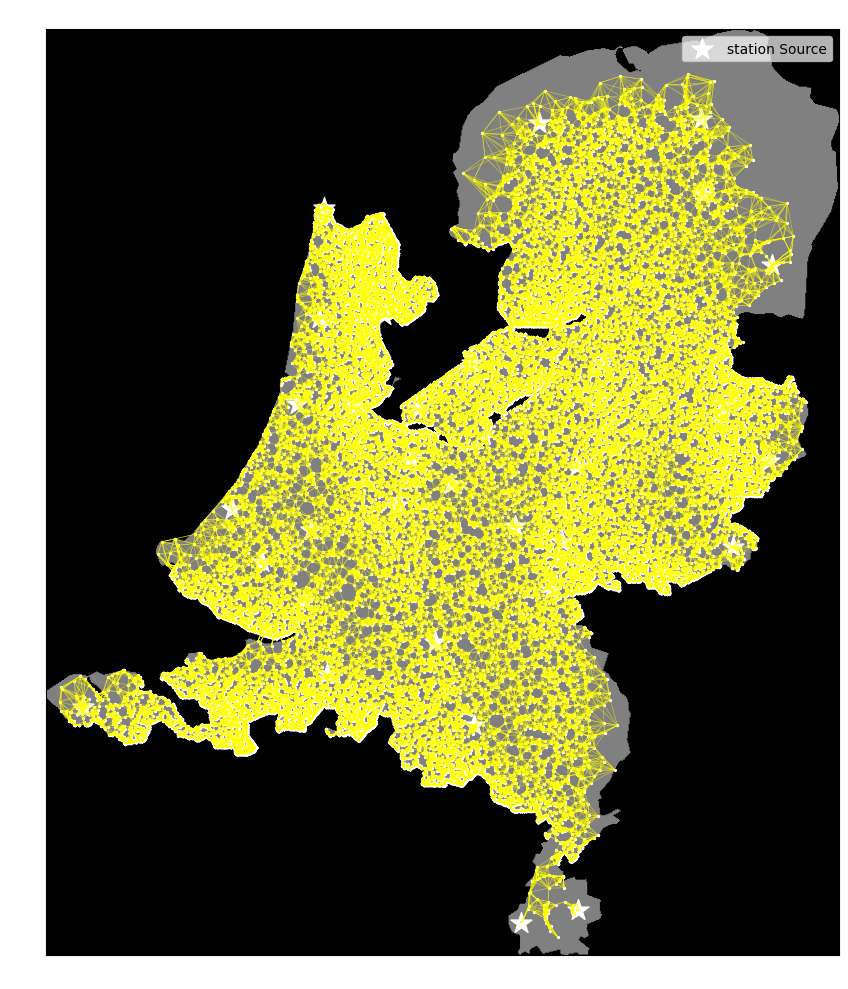

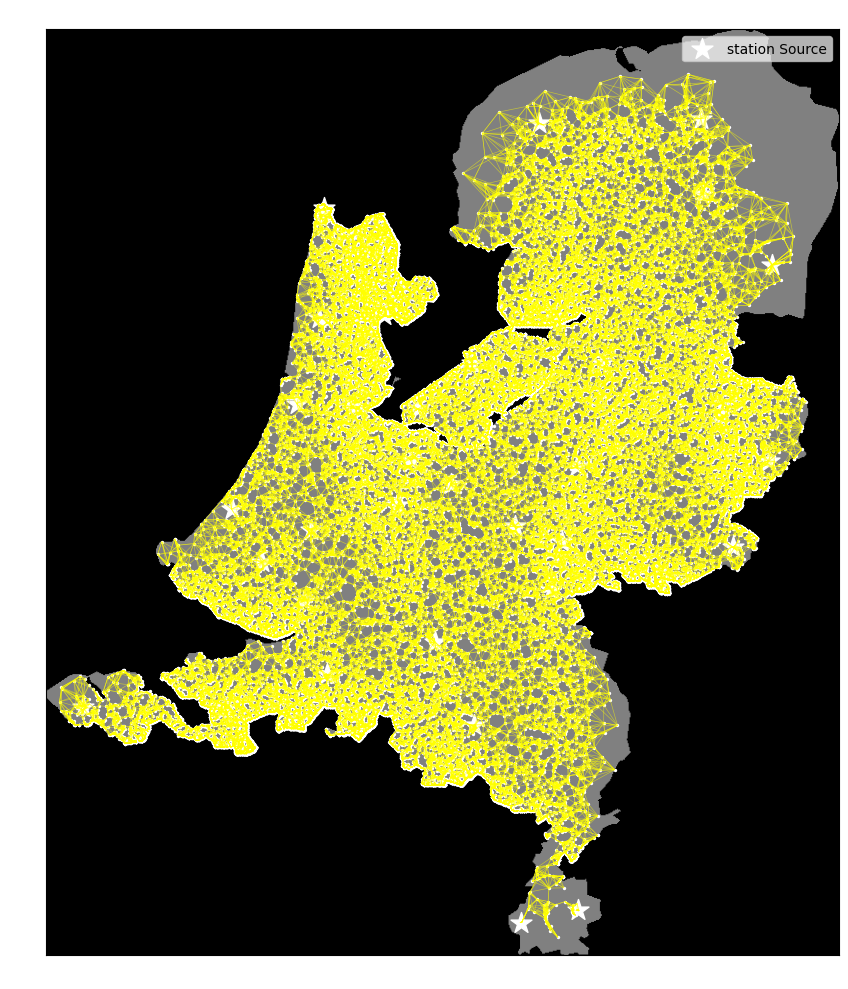

In [199]:
all_points, edges, G = build_proximity_graph(all_trails[0][::20], stations, pm=10)
pruned_edges = prune_edges_by_map(edges, all_points, map_with_stations, max_water_crossings=2)
# create a graph from the pruned edges
pruned_graph = nx.Graph()
pruned_graph.add_edges_from(pruned_edges)
# add the weights to the pruned graph
for (i, j) in pruned_edges:
    weight = G[i][j]['weight']
    pruned_graph[i][j]['weight'] = weight

visualize_mesh_with_background(all_points, edges, stations, map_with_stations,
                              title='10-Nearest Neighbor Proximity Mesh')

visualize_mesh_with_background(all_points, pruned_edges, stations, map_with_stations,
                              title='10-Nearest Neighbor Proximity Mesh with Pruned Edges')


In [200]:
def build_refined_station_network(G, all_points, station_points, p=3):
    """
    Build a refined network connecting each station to its p nearest station neighbors,
    using only mesh edges from the original graph G.

    Args:
        G: networkx.Graph, the mesh network (with weights).
        all_points: (N, 2) array of all points (nuclei + stations).
        station_points: (K, 2) array of station coordinates (x, y).
        p: number of nearest neighbors for each station.

    Returns:
        refined_edges: (M, 2) array of edge indices (into all_points).
        refined_segments: (M, 2, 2) array of edge segments for plotting.
        station_indices: indices of stations in all_points.
    """
    from scipy.spatial import distance_matrix
    # Indices of station sources in all_points (they are last in the array)
    station_indices = np.arange(all_points.shape[0] - len(station_points), all_points.shape[0])

    # Compute pairwise distances between station sources
    station_coords = all_points[station_indices]
    station_dmat = distance_matrix(station_coords, station_coords)

    # For each station source, get indices of its p closest station source neighbors (excluding self)
    np.fill_diagonal(station_dmat, np.inf)
    closest_neighbors = np.argsort(station_dmat, axis=1)[:, :p]

    # Build set of unique station source pairs to connect (undirected)
    station_pairs = set()
    for i, nbrs in enumerate(closest_neighbors):
        for j in nbrs:
            # Convert local indices to global indices in all_points
            a, b = station_indices[i], station_indices[j]
            station_pairs.add(tuple(sorted((a, b))))

    # --- Build refined network using only mesh edges ---
    edge_set = set()
    for a, b in station_pairs:
        try:
            path = nx.shortest_path(G, source=a, target=b, weight='weight')
            edge_set.update((min(path[k], path[k+1]), max(path[k], path[k+1])) for k in range(len(path)-1))
        except nx.NetworkXNoPath:
            continue

    # Convert edge_set to array for vectorized plotting
    refined_edges = np.array(list(edge_set))
    refined_segments = np.stack([all_points[refined_edges[:, 0]], all_points[refined_edges[:, 1]]], axis=1)
    return refined_edges, refined_segments, station_indices

In [202]:
refined_edges, refined_segments, station_indices = build_refined_station_network(pruned_graph, all_points, stations, p=3)

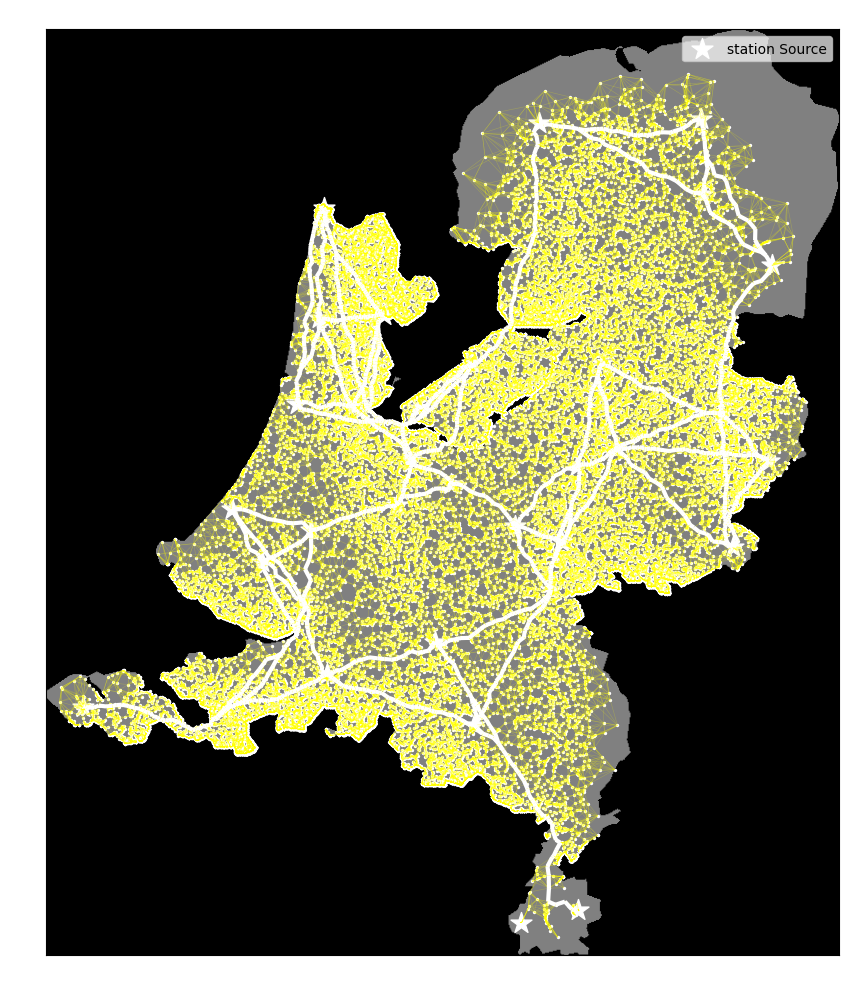

In [203]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.set_facecolor('black')

# Optionally, overlay the mesh in the background (faint)
# Prepare edge segments for LineCollection
pruned_edge_segments = np.stack([
    np.stack([all_points[pruned_edges[:, 0]], all_points[pruned_edges[:, 1]]], axis=1)
], axis=0).reshape(-1, 2, 2)

# Draw pruned edges faintly
lc_pruned = LineCollection(pruned_edge_segments, colors='yellow', linewidths=0.5, alpha=0.2)
ax.add_collection(lc_pruned)

# Draw the map with stations
ax.imshow(map_with_stations.T, cmap='gray', origin='lower')

# Draw refined network edges
lc = LineCollection(refined_segments, colors='white', linewidths=3)
ax.add_collection(lc)

# Draw points
ax.scatter(all_points[:, 0], all_points[:, 1], c='white', s=2)
ax.scatter(stations[:, 0], stations[:, 1], c='white', marker='*', s=250, label='station Source')

ax.set_xlim(0, map_with_stations.shape[0])
ax.set_ylim(0, map_with_stations.shape[1])
ax.set_title('Refined Shortest-Walk Network (Stage 2)', color='white')
ax.legend(facecolor='white', framealpha=0.7, loc='upper right')
ax.tick_params(colors='white')
plt.tight_layout()
plt.savefig('slime_mold_refined_network.png', dpi=300)
plt.show()